In [17]:
import numpy as np
import matplotlib.pyplot as plt

In [18]:
import pandas as pd

A = np.array([[-64132, -80820, -84496, -57728, -88595, -83348, -87339], 
    [10149, 12260, 12451, 8634.3, 12705, 11367, 13071], 
    [-537.69, -619.90, -613.61, -442.77, -613.96, -533.98, -648.75], 
    [12.287, 13.27, 12.968, 10.593, 12.782, 11.685, 13.623]])
gmv = np.array([23303097.11, 25656057.94, 24167653.90, 24090714.95, 24332404.17, 17687717.30, 14831653.08])
#gmv = np.array([26161096.98, 28859416.46, 27457585.25, 27333511.76, 27931773.23, 19912396.65, 16650378.09])

n = 1000
c_rate = np.tile(np.linspace(0.0, 0.1, n), 7)
week = np.arange(7).repeat(n)
gmv = gmv.repeat(n)
df = pd.DataFrame({'week': week, 'c_rate': c_rate, 'gmv': gmv})
df['roi'] = df.apply(lambda x: A[0][int(x['week'])]*x['c_rate']**3 + A[1][int(x['week'])]*x['c_rate']**2 + A[2][int(x['week'])]*x['c_rate'] + A[3][int(x['week'])], axis=1)
df['dcost'] = df['c_rate']*df['gmv']
df['dgmv'] = df['roi']*df['dcost']
df

,week,c_rate,gmv,roi,dcost,dgmv
0,0,0.0000,23303097.11,12.287000,0.000000e+00,0.000000e+00
1,0,0.0001,23303097.11,12.233279,2.332642e+03,2.853586e+04
2,0,0.0002,23303097.11,12.179761,4.665285e+03,5.682205e+04
3,0,0.0003,23303097.11,12.126445,6.997927e+03,8.485998e+04
4,0,0.0004,23303097.11,12.073332,9.330569e+03,1.126511e+05
...,...,...,...,...,...,...
6995,6,0.0996,14831653.08,-7.620949,1.477227e+06,-1.125787e+07
6996,6,0.0997,14831653.08,-7.685569,1.478711e+06,-1.136474e+07
6997,6,0.0998,14831653.08,-7.750451,1.480196e+06,-1.147219e+07
6998,6,0.0999,14831653.08,-7.815594,1.481681e+06,-1.158021e+07


In [19]:
from ortools.linear_solver import pywraplp

x = {}
solver = pywraplp.Solver.CreateSolver('CBC')
solver.max_time_in_seconds = 240.0
for i in range(len(df)):
    x[i] = solver.IntVar(0.0, 1, 'x[%i]' % (i))

budget = 5827978
#budget = 6000000
solver.Add(solver.Sum([x[i] * df['dcost'].iloc[i] for i in range(0, len(x))]) <= budget)
for a in range(7):
    solver.Add(solver.Sum([x[i] for i in range(a * n, (a + 1) * n)]) == 1)

solver.Minimize(-(solver.Sum([x[i] * df['dgmv'].iloc[i] for i in range(0, len(x))])))
status = solver.Solve()

In [20]:
optim = df.loc[[bool(x[i].solution_value()) for i in range(0, len(x))], :]
optim

,week,c_rate,gmv,roi,dcost,dgmv
175,0,0.017518,23303097.11,5.637622,4.082124e+05,2.301347e+06
1163,1,0.016316,25656057.94,6.068336,4.186124e+05,2.540281e+06
2581,2,0.058158,24167653.90,2.774060,1.405546e+06,3.899070e+06
3575,3,0.057558,24090714.95,2.704951,1.386603e+06,3.750692e+06
4160,4,0.016016,24332404.17,5.843826,3.897082e+05,2.277387e+06
5521,5,0.052152,17687717.30,2.930725,9.224525e+05,2.703454e+06
6604,6,0.060460,14831653.08,2.876989,8.967286e+05,2.579878e+06


In [21]:
print('总补贴率：%.2f%%' % (100 * optim['dcost'].sum()/optim['gmv'].sum()))
print('总ROI：%.2f' % (optim['dgmv'].sum()/optim['dcost'].sum()))

总补贴率：3.78%
总ROI：3.44


In [22]:
# y = a * cost**4/gmv**3 + b * cost**3/gmv**2 + c * cost**2/gmv + d * cost
# dy_dcost = 4 * a * cost**3/gmv**3 + 3 * b * cost**2/gmv**2 + 2 * c * cost/gmv + d
optim['ddgmv_ddcost'] = optim.apply(lambda x: 4 * A[0][int(x['week'])] * x['c_rate']**3 + 3 * A[1][int(x['week'])] * x['c_rate']**2 + 2 * A[2][int(x['week'])] * x['c_rate'] + A[3][int(x['week'])], axis=1)
optim

/var/folders/4j/b98762_920d7djjtybtsfm480000gn/T/ipykernel_7412/3548304693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  optim['ddgmv_ddcost'] = optim.apply(lambda x: 4 * A[0][int(x['week'])] * x['c_rate']**3 + 3 * A[1][int(x['week'])] * x['c_rate']**2 + 2 * A[2][int(x['week'])] * x['c_rate'] + A[3][int(x['week'])], axis=1)


,week,c_rate,gmv,roi,dcost,dgmv,ddgmv_ddcost
175,0,0.017518,23303097.11,5.637622,4.082124e+05,2.301347e+06,1.413120
1163,1,0.016316,25656057.94,6.068336,4.186124e+05,2.540281e+06,1.428430
2581,2,0.058158,24167653.90,2.774060,1.405546e+06,3.899070e+06,1.451189
3575,3,0.057558,24090714.95,2.704951,1.386603e+06,3.750692e+06,1.405988
4160,4,0.016016,24332404.17,5.843826,3.897082e+05,2.277387e+06,1.436694
5521,5,0.052152,17687717.30,2.930725,9.224525e+05,2.703454e+06,1.447810
6604,6,0.060460,14831653.08,2.876989,8.967286e+05,2.579878e+06,1.305790


In [23]:
df['ddgmv_ddcost'] = df.apply(lambda x: 4 * A[0][int(x['week'])] * x['c_rate']**3 + 3 * A[1][int(x['week'])] * x['c_rate']**2 + 2 * A[2][int(x['week'])] * x['c_rate'] + A[3][int(x['week'])], axis=1)
df

,week,c_rate,gmv,roi,dcost,dgmv,ddgmv_ddcost
0,0,0.0000,23303097.11,12.287000,0.000000e+00,0.000000e+00,12.287000
1,0,0.0001,23303097.11,12.233279,2.332642e+03,2.853586e+04,12.179659
2,0,0.0002,23303097.11,12.179761,4.665285e+03,5.682205e+04,12.072927
3,0,0.0003,23303097.11,12.126445,6.997927e+03,8.485998e+04,11.966802
4,0,0.0004,23303097.11,12.073332,9.330569e+03,1.126511e+05,11.861282
...,...,...,...,...,...,...,...
6995,6,0.0996,14831653.08,-7.620949,1.477227e+06,-1.125787e+07,-71.787686
6996,6,0.0997,14831653.08,-7.685569,1.478711e+06,-1.136474e+07,-72.177050
6997,6,0.0998,14831653.08,-7.750451,1.480196e+06,-1.147219e+07,-72.567722
6998,6,0.0999,14831653.08,-7.815594,1.481681e+06,-1.158021e+07,-72.959705


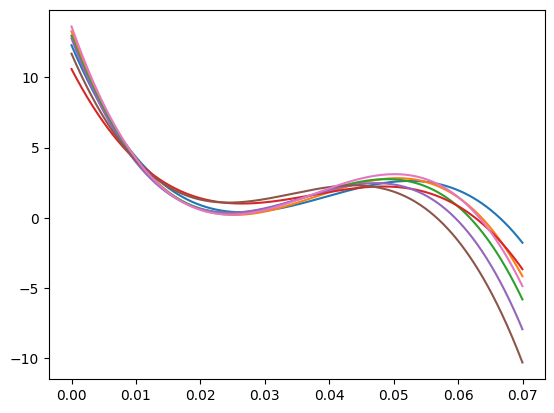

In [24]:
# 一阶导图像
for w in range(7):
    df1 = df[(df['week'] == w) & (df['c_rate'] < 0.07)] 
    plt.plot(df1['c_rate'], df1['ddgmv_ddcost'])

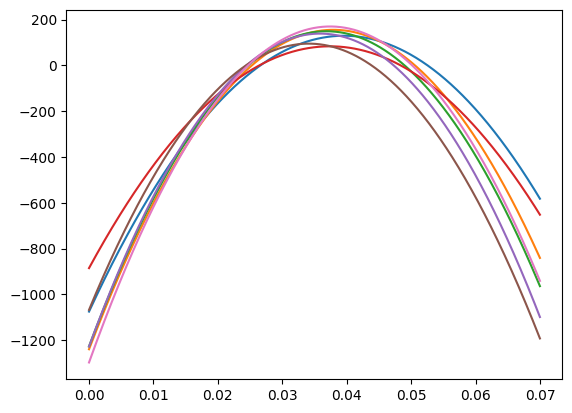

In [ ]:
# 二阶导约束条件检验
# ROI = a * x**3 + b * x**2 + c * x + d
# d1ROI = 3 * a * x**2 + 2 * b * x + c
# d2ROI = 6 * a * x + 2 * b
# d2 = 12 * a * x**2 + 6 * b * x + 2 * c
df['d2'] = df.apply(lambda x: 12 * A[0][int(x['week'])] * x['c_rate']**2 + 6 * A[1][int(x['week'])] * x['c_rate'] + 2 * A[2][int(x['week'])], axis=1)
for w in range(7):
    df3 = df[(df['week'] == w) & (df['c_rate'] < 0.07)] 
    plt.plot(df3['c_rate'], df3['d2'])

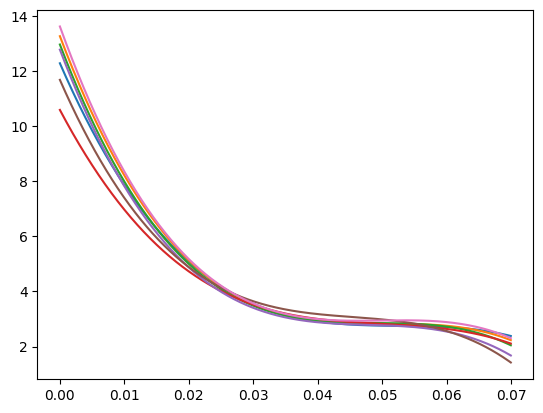

In [ ]:
for w in range(7):
    df3 = df[(df['week'] == w) & (df['c_rate'] < 0.07)] 
    plt.plot(df3['c_rate'], df3['roi'])